Best so far but old features
No fold

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [3]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [4]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [5]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [6]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [7]:
def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

In [8]:
def create_combined_model_with_prot_t5(seq_length=33, struct_features=12, struct_window=0):
    regularizer = tf.keras.regularizers.l2(0.01)
    
    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', 
                                 kernel_regularizer=regularizer, 
                                 name='seq_features')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)

    # Structure track
    # Structure track with adaptive dense layer size
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    # Extract window around middle position
    if struct_window == 0:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos:middle_pos+1, :]
        )(struct_input)
    else:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos-struct_window:middle_pos+struct_window+1, :]
        )(struct_input)

    struct_positions = 1 + (2 * struct_window)
    total_struct_features = struct_positions * struct_features
    
    # Make dense layer size proportional to input features
    struct_dense_size = min(total_struct_features * 2, 128)  # or another scaling rule
        
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)

    # ProtT5 track
    prot_t5_input = tf.keras.layers.Input(shape=(1024,), name='prot_t5_input')
    x_prot_t5 = tf.keras.layers.Dense(256, kernel_regularizer=regularizer)(prot_t5_input)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dense(128, activation='relu',
                                     kernel_regularizer=regularizer)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)

    # Create learnable weights layer
    weight_layer = tf.keras.layers.Dense(3, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_struct, x_prot_t5]))

    # Apply weights
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    weighted_prot_t5 = tf.keras.layers.Multiply(name='weighted_prot_t5')([
        x_prot_t5,
        tf.keras.layers.Lambda(lambda x: x[:, 2:3])(track_weights)
    ])

    # Combine features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_struct, weighted_prot_t5])

    # Final layers with more regularization
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=regularizer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32, activation='relu', 
                            kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, struct_input, prot_t5_input], outputs=outputs)
    
    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1]),
                'prot_t5': float(normalized[2])
            }
        return {'sequence': 0.33, 'structure': 0.33, 'prot_t5': 0.34}

    model.get_track_weights = get_track_weights
    return model

In [9]:
def train_and_evaluate(struct_window=0):
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/old data/processed_data_train_after.csv")
    test_df = pd.read_csv("../data/old data/processed_data_test_after.csv")
    
    # Load ProtT5 embeddings
    print("Loading ProtT5 embeddings...")
    train_pos_dict, train_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_negative_ProtT5-XL-UniRef50.csv'
    )
    test_pos_dict, test_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_negative_ProtT5-XL-UniRef50.csv'
    )
    
    # Align data
    print("Aligning data...")
    X_train_prot_t5, train_df_aligned = prepare_aligned_data(train_df, train_pos_dict, train_neg_dict)
    X_test_prot_t5, test_df_aligned = prepare_aligned_data(test_df, test_pos_dict, test_neg_dict)
    
    # Prepare other data
    X_train_seq = prepare_sequence_data(train_df_aligned)
    X_test_seq = prepare_sequence_data(test_df_aligned)
    X_train_struct = prepare_structure_data(train_df_aligned)
    X_test_struct = prepare_structure_data(test_df_aligned)
    
    y_train = train_df_aligned['label'].values
    y_test = test_df_aligned['label'].values
    
    # Split training data into train and validation sets
    train_idx, val_idx = train_test_split(
        np.arange(len(y_train)), 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train
    )
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(pd.Series(y_train[train_idx]).value_counts())
    print("\nValidation set distribution:")
    print(pd.Series(y_train[val_idx]).value_counts())
    print("\nTest set distribution:")
    print(pd.Series(y_test).value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq[train_idx].shape}")
    print(f"X_val_seq: {X_train_seq[val_idx].shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    
    # Calculate class weights
    total_samples = len(train_idx)
    pos_samples = np.sum(y_train[train_idx] == 1)
    neg_samples = np.sum(y_train[train_idx] == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]
    
    # Create and compile model
    model = create_combined_model_with_prot_t5(
        seq_length=33,
        struct_features=X_train_struct.shape[2],
        struct_window=struct_window
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        [X_train_seq[train_idx], X_train_struct[train_idx], X_train_prot_t5[train_idx]], 
        y_train[train_idx],
        validation_data=(
            [X_train_seq[val_idx], X_train_struct[val_idx], X_train_prot_t5[val_idx]], 
            y_train[val_idx]
        ),
        batch_size=32,
        epochs=50,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Get track weights
    final_weights = model.get_track_weights()
    print("\nLearned track weights:")
    print(f"Sequence weight: {final_weights['sequence']:.4f}")
    print(f"Structure weight: {final_weights['structure']:.4f}")
    print(f"ProtT5 weight: {final_weights['prot_t5']:.4f}")
    
    # Evaluate on validation set
    y_val_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx], X_train_prot_t5[val_idx]])
    y_val_pred_binary = (y_val_pred > 0.5).astype(int)
    
    # Calculate validation metrics
    cm_val = confusion_matrix(y_train[val_idx], y_val_pred_binary)
    print("\nValidation Set Results:")
    print(f"Accuracy: {accuracy_score(y_train[val_idx], y_val_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_train[val_idx], y_val_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_train[val_idx], y_val_pred_binary):.4f}")
    print(f"Sensitivity: {cm_val[1][1]/(cm_val[1][1]+cm_val[1][0]):.4f}")
    print(f"Specificity: {cm_val[0][0]/(cm_val[0][0]+cm_val[0][1]):.4f}")
    
    # Evaluate on test set
    y_test_pred = model.predict([X_test_seq, X_test_struct, X_test_prot_t5])
    y_test_pred_binary = (y_test_pred > 0.5).astype(int)
    
    # Calculate test metrics
    cm_test = confusion_matrix(y_test, y_test_pred_binary)
    print("\nTest Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution:
1    3674
0    3406
Name: count, dtype: int64

Validation set distribution:
1    918
0    852
Name: count, dtype: int64

Test set distribution:
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (7080, 33)
X_val_seq: (1770, 33)
X_test_seq: (2737, 33)


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-16 13:05:49.662880: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-16 13:05:49.662901: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-16 13:05:49.662915: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-16 13:05:49.663148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 13:05:49.663159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-16 13:05:51.202322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.4998 - loss: 7.9499 - val_accuracy: 0.5514 - val_loss: 5.6008 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.5298 - loss: 5.1101 - val_accuracy: 0.6350 - val_loss: 3.4845 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.5606 - loss: 3.1547 - val_accuracy: 0.6774 - val_loss: 2.2024 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - accuracy: 0.6126 - loss: 2.0264 - val_accuracy: 0.7090 - val_loss: 1.5119 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - accuracy: 0.6632 - loss: 1.4576 - val_accuracy: 0.7136 - val_loss: 1.1737 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.6853 - loss: 1.1574 - val_accuracy: 0.6356 - val_loss: 1.0544 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7024 - loss:

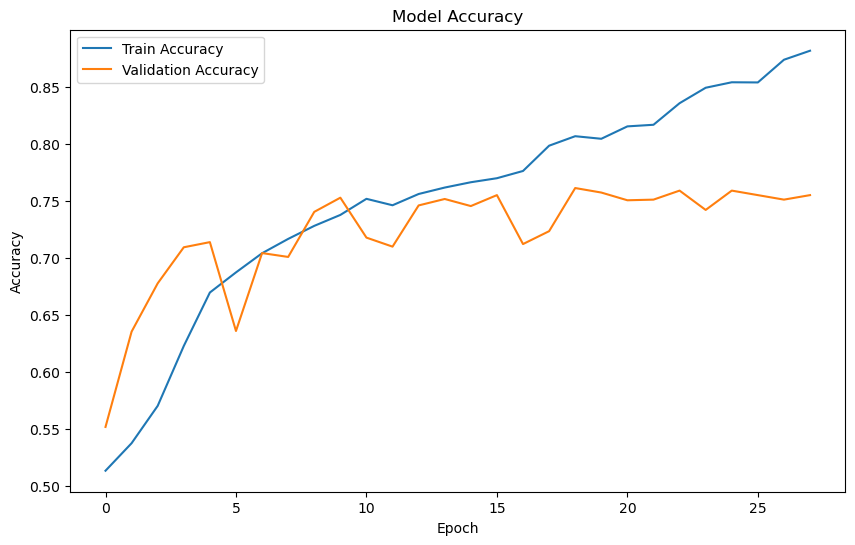


Learned track weights:
Sequence weight: 0.4203
Structure weight: 0.2512
ProtT5 weight: 0.3285
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Validation Set Results:
Accuracy: 0.7588
Balanced Accuracy: 0.7590
MCC: 0.5177
Sensitivity: 0.7516
Specificity: 0.7664
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Test Set Results:
Accuracy: 0.7596
Balanced Accuracy: 0.7458
MCC: 0.3095
Sensitivity: 0.7292
Specificity: 0.7625
Confusion Matrix:
[[1904  593]
 [  65  175]]


In [10]:
model = train_and_evaluate()

In [11]:
# struc_window = 0
# for i in range(0, 5):
#     if __name__ == "__main__":
#         print("Struct window: ", i)
#         model = train_and_evaluate(struct_window=i)
#         print("#"*50)